In [1]:
import os, sys
import warnings
warnings.filterwarnings("ignore")

import scanpy as sc
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import rcParams


In [2]:
path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/'
table_path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/results/tables/new/'
figure_path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/results/figures/new/'


In [3]:
adata = sc.read_h5ad(path+'data/ALO_viscRNAseq.h5ad')
adata

AnnData object with n_obs × n_vars = 21044 × 39895
    obs: 'species', 'run', 'ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'high_quality', 'viral_counts', 'cell_type'
    var: 'gene_id', 'gene_name', 'genome'

In [5]:
filtered =adata[(adata.obs.high_quality=='True') & 
               (adata.obs.cell_type.isin(['AT2-like cells'])) &
                (adata.obs.ID.isin(['24h_infected_DMSO', '24h_infected_RMC-113', '24h_uninfected_DMSO', '24h_uninfected_RMC-113']))
               ]
filtered

View of AnnData object with n_obs × n_vars = 5708 × 39895
    obs: 'species', 'run', 'ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'high_quality', 'viral_counts', 'cell_type'
    var: 'gene_id', 'gene_name', 'genome'

In [6]:
### Normalize RNA counts
filtered.layers['counts'] = filtered.X.copy()

sc.pp.normalize_total(filtered, target_sum=1e6)
sc.pp.log1p(filtered, base=2)
filtered.raw = filtered.copy()

In [7]:
def sample_and_compare(adata1, adata2, n_sample=0, n=100, log1p=2):
    
    from random import sample
    if n_sample == 0: n_sample = min(adata1.shape[0], adata2.shape[0])

    var_names = [x for x in adata1.var_names if x in adata2.var_names]
    results = pd.DataFrame(np.zeros((n, len(var_names)), np.float64),
                           columns=var_names,
                          )

    for x in np.arange(n):
        # w/o replacement
        samplelist1 = sample(list(adata1.obs_names), n_sample)
        samplelist2 = sample(list(adata2.obs_names), n_sample)
        
        adata_1 = adata1[np.in1d(adata1.obs.index, samplelist1),:]
        adata_2 = adata2[np.in1d(adata2.obs.index, samplelist2),:]
        
        # Compute averages
        avg1 = adata_1.X.mean(axis=0)
        avg2 = adata_2.X.mean(axis=0)
        
        # Compute log2 fold changes
        if log1p is False: log2_fc = np.log2(avg1 + 1) - np.log2(avg2 + 1)
        elif log1p not in (True, 2): log2_fc = (avg1 - avg2) / np.log2(log1p)
        else: log2_fc = avg1 - avg2
        
        results.loc[x] = log2_fc

    return results


def boxplot_from_log2FC(log2FCs, title='all_cell_types', xlim=3, cbar_label= 'log2 fold change \n(VHCs vs bystanders)\n24h_infected_DMSO', height=5, aspect = 0.5, vmin=-1.5, vmax = 1.5):
    fig, ax = plt.subplots(figsize=[height*aspect, height])
    cmap = sns.diverging_palette(245, 5, as_cmap=True)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    palette = [cmap(norm(x)) for x in np.clip(log2FCs.median(axis=0), vmin, vmax)]
    sns.boxplot(data=log2FCs, orient="h", ax=ax, palette=palette)
    ax.set_title(title)
    ax.set_xlim(xlim*-1, xlim)
    ax.tick_params(labelsize=12)
    #ax.set_xticks([str(x) for x in np.linspace(vmin,vmax,1)])
    for x in [-1, 0, 1]:
        ax.axvline(x, c='black', ls='-.', lw=0.5, zorder=0.5)
    
    ax_cb = fig.add_axes([0.15, 0.04, 0.65, 0.02])
    cbar = mpl.colorbar.ColorbarBase(ax_cb, norm=norm, cmap=cmap, orientation='horizontal')
    cbar.set_ticks(list(range(vmin, vmax+1, 1)))
    cbar.set_ticklabels([str(x) for x in list(range(vmin, vmax+1, 1))])
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(cbar_label)

    return fig, ax
#fig.tight_layout()
#data_path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/'
#fig.savefig(data_path + 'results/figures/24h_infected_RMC113_box_DEGs_VHCs_autophagy_more_than_3vRNAs.pdf', bbox_inches='tight')

In [14]:
marker_genes = ["MTOR", ## "mTORC1", 
                "ULK1", "ATG13",
                "RB1CC1", ## "FIP200",
                "BECN1", 
                'ATG7', 'ATG8', 'ATG10', 'ATG12', 'ATG16L1', 
                'MAP1LC3B', 'SQSTM1', 
                'WDFY3','NBR1', 'TAX1BP1',
                "LAMP2", "TECPR1",
                "ATG14", "STX17", "VAMP8",
                "SNAP29", "RAB7A",  
                "PLEKHM1", "GABARAP",
                "VPS11", "VPS16", "VPS18",
                "VPS33A", "VPS33B", ## "Vps33", 
                   "VPS39", "VPS41",
                ]
genes = [x.upper() for x in marker_genes if x.upper() in filtered.var_names]
filtered = filtered[:,genes].copy()

filtered.obs['bystanders'] = 'low'
filtered.obs.loc[filtered.obs.viral_counts==0, 'bystanders'] = 'zero'
filtered.obs.loc[filtered.obs.viral_counts>3, 'bystanders'] = 'high'


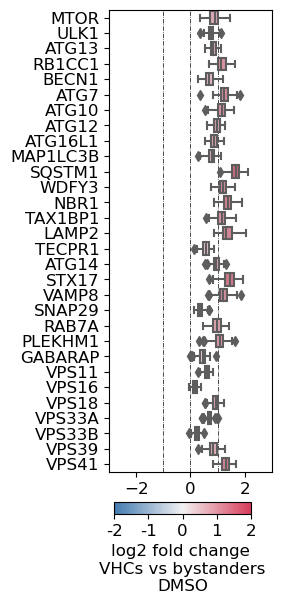

In [18]:
### Supplementary Fig. 8e

from matplotlib import rcParams
rcParams['font.size']=12

cond='bystanders'
samp='DMSO'
s = f'24h_infected_{samp}'
n_sample = 0

adata_s = filtered[filtered.obs.ID.str.startswith(s)].copy()
adata1 = adata_s[adata_s.obs.bystanders.isin(['high'])]
adata2 = adata_s[adata_s.obs.bystanders == 'zero']

log2fc_temp = sample_and_compare(adata1, adata2, n_sample=n_sample, n=100, log1p=2)
fig, ax = boxplot_from_log2FC(log2fc_temp, xlim=3, vmin=-2, vmax=2,
                              title='',
                              height=6, aspect = 0.35, 
                              cbar_label= f'log2 fold change \nVHCs vs {cond}\n{samp}',
                             )
plt.show()
#fig.savefig(figure_path + f'boxplot_autophagy_genes_AT2_VHCs_vs_{cond}_{samp}_{n_sample}_new_allVHC.svg', bbox_inches='tight')


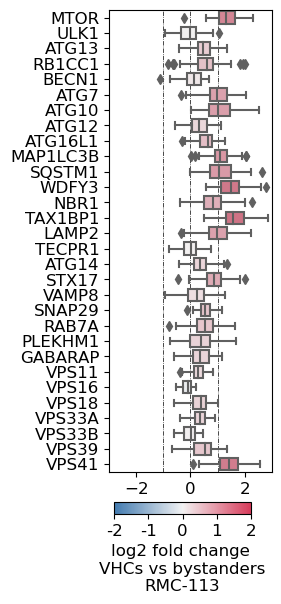

In [21]:
### Supplementary Fig. 8f

from matplotlib import rcParams
rcParams['font.size']=12

cond='bystanders'
samp='RMC-113'
s = f'24h_infected_{samp}'

adata_s = filtered[filtered.obs.ID.str.startswith(s)].copy()
adata1 = adata_s[adata_s.obs.bystanders.isin(['high'])]
adata2 = adata_s[adata_s.obs.bystanders == 'zero']

log2fc_temp = sample_and_compare(adata1, adata2, n_sample=n_sample, n=100, log1p=2)
fig, ax = boxplot_from_log2FC(log2fc_temp, xlim=3, vmin=-2, vmax=2,
                              title='',
                              height=6, aspect = 0.35, 
                              cbar_label= f'log2 fold change \nVHCs vs {cond}\n{samp}',
                             )
plt.show()
#fig.savefig(figure_path + f'boxplot_autophagy_genes_AT2_VHCs_vs_{cond}_{samp}_{n_sample}_new_allVHC.svg', bbox_inches='tight')


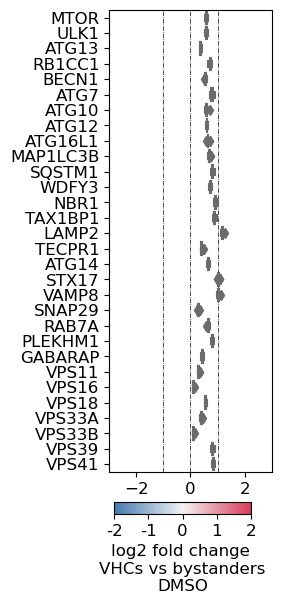

In [22]:
from matplotlib import rcParams
rcParams['font.size']=12

cond='bystanders'
samp='DMSO'
s = f'24h_infected_{samp}'

adata_s = filtered[filtered.obs.ID.str.startswith(s)].copy()
adata1 = adata_s[adata_s.obs.bystanders.isin(['high', 'low'])]
adata2 = adata_s[adata_s.obs.bystanders == 'zero']

log2fc_temp = sample_and_compare(adata1, adata2, n_sample=n_sample, n=100, log1p=2)
fig, ax = boxplot_from_log2FC(log2fc_temp, xlim=3, vmin=-2, vmax=2,
                              title='',
                              height=6, aspect = 0.35, 
                              cbar_label= f'log2 fold change \nVHCs vs {cond}\n{samp}',
                             )
plt.show()
#fig.savefig(figure_path + f'boxplot_autophagy_genes_AT2_VHCs_vs_{cond}_{samp}_{n_sample}_new_allVHC.svg', bbox_inches='tight')


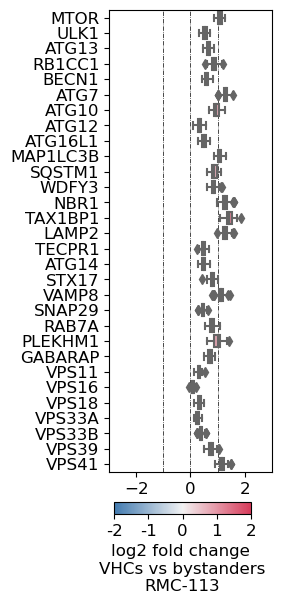

In [23]:
from matplotlib import rcParams
rcParams['font.size']=12

cond='bystanders'
samp='RMC-113'
s = f'24h_infected_{samp}'

adata_s = filtered[filtered.obs.ID.str.startswith(s)].copy()
adata1 = adata_s[adata_s.obs.bystanders.isin(['high', 'low'])]
adata2 = adata_s[adata_s.obs.bystanders == 'zero']

log2fc_temp = sample_and_compare(adata1, adata2, n_sample=n_sample, n=100, log1p=2)
fig, ax = boxplot_from_log2FC(log2fc_temp, xlim=3, vmin=-2, vmax=2,
                              title='',
                              height=6, aspect = 0.35, 
                              cbar_label= f'log2 fold change \nVHCs vs {cond}\n{samp}',
                             )
plt.show()
#fig.savefig(figure_path + f'boxplot_autophagy_genes_AT2_VHCs_vs_{cond}_{samp}_{n_sample}_new_allVHC.svg', bbox_inches='tight')
